In [11]:
import os, time, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image

In [2]:
class Config:
    lr = 2e-4
    batch_size = 64
    num_epochs = 200
    sample_interval = 200
    sample_save_dir = './result/pix2pix'
    lamda = 100

os.makedirs(Config.sample_save_dir, exist_ok=True)

In [3]:
# %%capture
# !mkdir dataset
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
# !tar -zxvf facades.tar.gz -C ./dataset
# !rm -rf facades.tar.gz

In [4]:
print("학습 데이터셋 A와 B의 개수:", len(next(os.walk('./dataset/facades/train/'))[2]))
print("평가 데이터셋 A와 B의 개수:", len(next(os.walk('./dataset/facades/val/'))[2]))
print("테스트 데이터셋 A와 B의 개수:", len(next(os.walk('./dataset/facades/test/'))[2]))

학습 데이터셋 A와 B의 개수: 400
평가 데이터셋 A와 B의 개수: 100
테스트 데이터셋 A와 B의 개수: 106


이미지 크기: (512, 256)


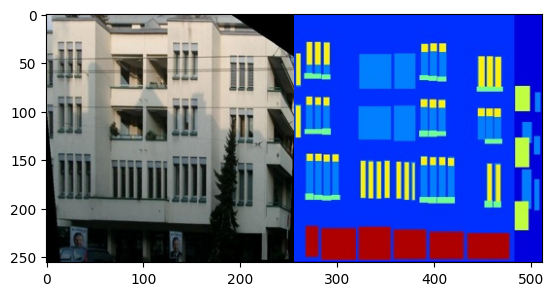

In [5]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('./dataset/facades/train/1.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode="train"):
        self.transform = transform

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.jpg"))
        # 데이터의 개수가 적기 때문에 테스트 데이터를 학습 시기에 사용
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.jpg")))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_B = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반
        img_A = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반

        # 데이터 증진(data augmentation)을 위한 좌우 반전(horizontal flip)
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)


pix2pix_transform = transforms.Compose([
    # transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("./dataset/facades", transform=pix2pix_transform)
val_dataset = ImageDataset("./dataset/facades", transform=pix2pix_transform)

train_data_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)
val_data_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=4)

In [7]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def block(in_channels, out_channels, normalization=True):
            '''
                높이와 너비가 2배씩 감소
            '''
            layers = []
            layers.append(
                nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=4,
                            stride=2,
                            padding=1,
                        )
            )
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels * 2, 64, normalization=False), # out : bx64x128x128
            *block(64, 128), # out : bx128x64x64
            *block(128, 256), # out : bx256x32x32
            *block(256, 512), # out : bx512x16x16
            nn.Conv2d(512, 1, kernel_size=3, padding=1, bias=False) # out : bx1x16x16,
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        input = torch.cat((img_A, img_B), 1)
        out = self.model(input)
        out = torch.sigmoid(out)
        return out


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [8]:
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

adversarial_loss.cuda()
l1_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=Config.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=Config.lr, betas=(0.5, 0.999))

loss_history={'gen':[],
              'dis':[]}

In [9]:
generator.train()
discriminator.train()

start_time = time.time()

for epoch in range(Config.num_epochs):
    for i, batch in enumerate(train_data_loader):

        real_A = batch['A'].cuda()
        real_B = batch['B'].cuda()

        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0
        
        ''' Generator ''' 
        optimizer_G.zero_grad()

        fake_B = generator(real_A)

        g_loss = adversarial_loss(discriminator(real_A, fake_B), real)
        pixl_loss = l1_loss(fake_B, real_B)
        g_total_loss = g_loss + Config.lamda * pixl_loss
        g_total_loss.backward()
        optimizer_G.step()

        ''' Discriminator ''' 
        optimizer_D.zero_grad()

        loss_real = adversarial_loss(discriminator(real_A, real_B), real) 
        loss_fake = adversarial_loss(discriminator(real_A, fake_B.detach()), fake)
        d_total_loss = loss_real + loss_fake
        d_total_loss.backward()
        optimizer_D.step()

        loss_history['gen'].append(g_total_loss.item())
        loss_history['dis'].append(d_total_loss.item())

        done = epoch * len(train_data_loader) + i
        if done % Config.sample_interval == 0:
            imgs = next(iter(val_data_loader))
            real_A = imgs["A"].cuda()
            real_B = imgs["B"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{Config.sample_save_dir}/{done}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{Config.num_epochs}] [D loss: {d_total_loss.item():.6f}] [G loss: {g_total_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 1.395726] [G loss: 38.809685] [Elapsed time: 9.03s]
[Epoch 1/200] [D loss: 1.328717] [G loss: 38.567661] [Elapsed time: 12.71s]
[Epoch 2/200] [D loss: 0.971112] [G loss: 36.696983] [Elapsed time: 16.44s]
[Epoch 3/200] [D loss: 0.752580] [G loss: 37.182266] [Elapsed time: 20.12s]
[Epoch 4/200] [D loss: 0.680546] [G loss: 36.339520] [Elapsed time: 23.80s]
[Epoch 5/200] [D loss: 0.478324] [G loss: 36.687626] [Elapsed time: 27.52s]
[Epoch 6/200] [D loss: 0.350617] [G loss: 37.476265] [Elapsed time: 31.25s]
[Epoch 7/200] [D loss: 0.653379] [G loss: 37.504993] [Elapsed time: 34.95s]
[Epoch 8/200] [D loss: 0.308599] [G loss: 37.982765] [Elapsed time: 38.64s]
[Epoch 9/200] [D loss: 0.340373] [G loss: 37.428806] [Elapsed time: 42.38s]
[Epoch 10/200] [D loss: 0.525475] [G loss: 36.365738] [Elapsed time: 46.10s]
[Epoch 11/200] [D loss: 0.456048] [G loss: 38.661705] [Elapsed time: 49.82s]
[Epoch 12/200] [D loss: 0.725833] [G loss: 35.132965] [Elapsed time: 53.51s]
[Epoch 13/

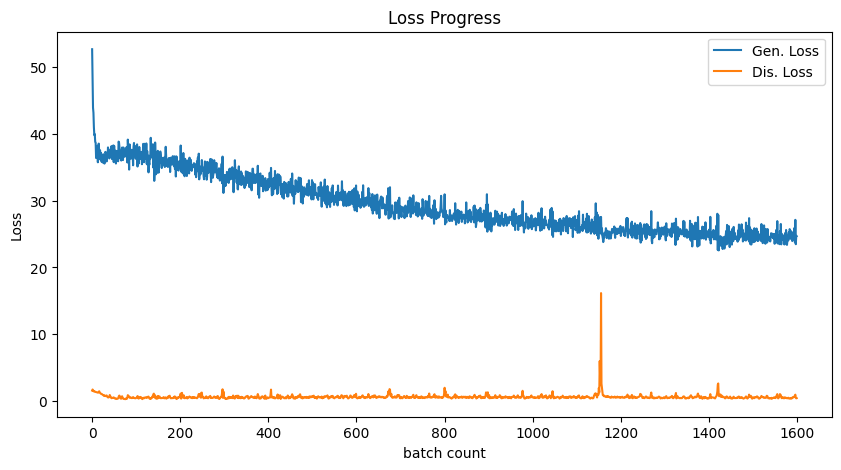

In [12]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
generator.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for batch in train_data_loader:
        real_A = batch['A'].cuda()
        real_B = batch['B'].cuda()

        fake_imgs = generator(real_A).detach().cpu()
        real_imgs = real_B
        break

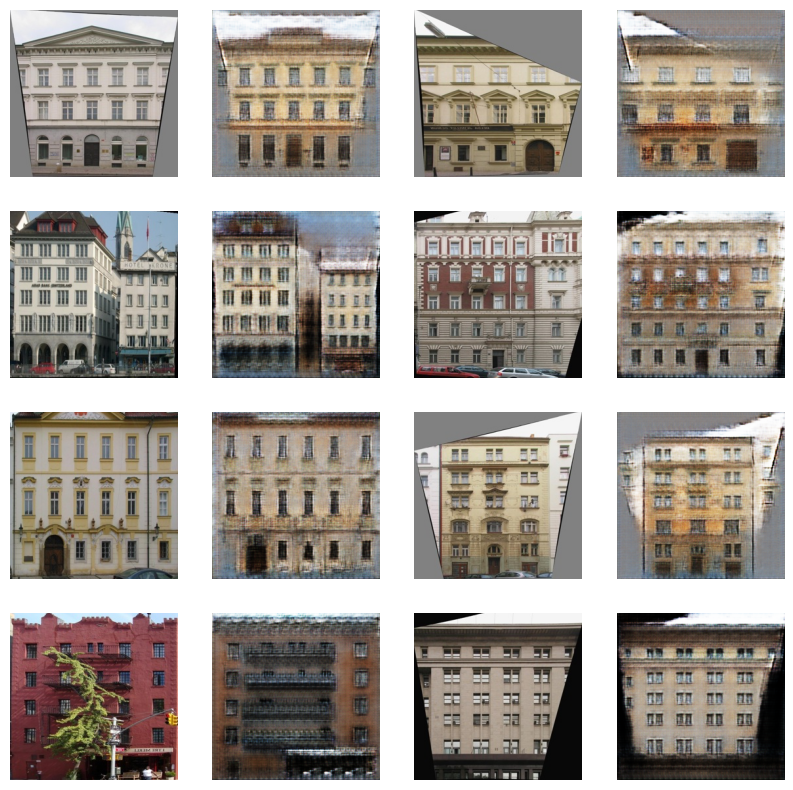

In [17]:
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')